In [9]:
using DifferentialEquations, LinearAlgebra, Statistics, Random, PyPlot, StaticArrays, PyCall

In [10]:
ENV["PYTHON"] = "C:\\Users\\admin\\Anaconda3\\envs\\data_vis\\python.exe"

LogNorm = pyimport("matplotlib.colors").LogNorm
cmap = pyimport("cmap")

lajolla = cmap.Colormap("crameri:lajolla").to_mpl();
balance = cmap.Colormap("cmocean:balance").to_mpl();
oslo = cmap.Colormap("crameri:oslo").to_mpl();
lipari = cmap.Colormap("crameri:lipari").to_mpl();
eclipse = cmap.Colormap("cmasher:eclipse").to_mpl();
bilbao = cmap.Colormap("crameri:bilbao").to_mpl();


# Configure LaTeX rendering and fonts
PyPlot.matplotlib[:rc]("text", usetex=true)
PyPlot.matplotlib[:rc]("font", family="serif", serif=["mathpazo"], size=18)  # Base font size
PyPlot.matplotlib[:rc]("axes", titlesize=22)             # Axis title
PyPlot.matplotlib[:rc]("axes", labelsize=20)             # Axis labels
PyPlot.matplotlib[:rc]("xtick", labelsize=18)            # X-ticks
PyPlot.matplotlib[:rc]("ytick", labelsize=18)            # Y-ticks
PyPlot.matplotlib[:rc]("legend", fontsize=18)            # Legend
PyPlot.matplotlib[:rc]("figure", titlesize=24)           # Figure title
PyPlot.svg(true)
# LaTeX preamble packages
PyPlot.matplotlib[:rc]("text.latex", preamble="\\usepackage{amsmath}\\usepackage{amsfonts}\\usepackage{amssymb}\\usepackage{lmodern}")

In [2]:
""" 

######
        build Gell-Mann λ-matrices for the su(3) algebra (NOTE 1/2 factor)
#######

"""

λ1 = 1/2 * [0 1 0;
        1 0 0;
        0 0 0]

λ2 = 1/2*[0 -im  0;
        im  0  0;
        0   0  0]

λ3 = 1/2*[1  0 0;
        0 -1 0;
        0  0 0]

λ4 = 1/2*[0 0 1;
        0 0 0;
        1 0 0]

λ5 = 1/2*[0  0 -im;
        0  0   0;
        im 0   0]

λ6 = 1/2*[0 0 0;
        0 0 1;
        0 1 0]

λ7 = 1/2*[0  0   0;
        0  0  -im;
        0  im  0]
        
λ8 = (1/(2*sqrt(3)))*[1   0   0;
                0   1   0;
                0   0  -2]

                

λ_matrices = [λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8]

sum(λ_matrices[i]^2 for i in 1:8)


"""
    su3_d_tensor(lambdas::Vector{<:AbstractMatrix})

Compute the fully symmetric d_{i,j,k} tensor for SU(3) by
d[i,j,k] = 1/4 * tr( (lambdas[i]*lambdas[j] + lambdas[j]*lambdas[i]) * lambdas[k] ).
Returns an Array{Float64,3} of size (8,8,8).
"""
function su3_d_tensor(lambdas::Vector{Matrix{ComplexF64}})
    d = zeros(Float64, 8, 8, 8)
    for i in 1:8, j in 1:8, k in 1:8
        # compute the anticommutator {λ_i, λ_j}
        A = lambdas[i]*lambdas[j] + lambdas[j]*lambdas[i]

        d[i, j, k] = tr(A * lambdas[k]) / 4
    end
    return d
end

#Sum with cubic casimir of lambda matrices
dsu3 = su3_d_tensor(λ_matrices);

C3m = zeros(ComplexF64, 3, 3)

# sum over i,j,k
for i in 1:8, j in 1:8, k in 1:8
    C3m .+= dsu3[i, j, k] * (λ_matrices[i] * λ_matrices[j] * λ_matrices[k])
end

# Define the system of ODEs
function coupled_eqs!(du, u, p, t)
    Δ1, Δ2, g, φ, Δ, κ, η = p
    λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8, α_re, α_im = u

    # reconstruct complex field
    α    = α_re + im*α_im
    αc   = conj(α)
    expp = cis(φ)               # e^{iφ}
    expm = conj(expp)           # e^{-iφ}

    # λ-derivatives 
    dλ1 = -Δ1*λ2 + im*g*(λ3*(α-αc) + expm*αc/2*(-im*λ5+λ4) + expp*α/2*(-im*λ5-λ4))
    dλ2 =  Δ1*λ1 + im*g*(im*λ3*(α+αc) + expm*αc/2*(im*λ4+λ5) + expp*α/2*(im*λ4-λ5))
    dλ3 =  im*g*(-im*λ2*(α+αc) + λ1*(αc-α) + expm*αc/2*(im*λ7-λ6) + expp*α/2*(im*λ7+λ6))
    dλ4 = (-Δ1-Δ2)*λ5 + im*g*(αc/2*(im*λ7+λ6) + α/2*(im*λ7-λ6) + expm*αc/2*(-im*λ2-λ1) + expp*α/2*(-im*λ2+λ1))
    dλ5 = -(-Δ1-Δ2)*λ4 + im*g*(αc/2*(-im*λ6+λ7) + α/2*(-im*λ6-λ7) + expm*αc/2*(im*λ1-λ2) + expp*α/2*(im*λ1+λ2))
    dλ6 = -(Δ2)*λ7 + im*g* ( αc/2*(im*λ5-λ4) + α/2*(im*λ5+λ4) + 1/2*(expp*α - expm*αc)*(sqrt(3)*λ8 - λ3) )                 
    dλ7 =  (Δ2)*λ6 + im*g* ( αc/2*(-im*λ4-λ5) + α/2*(-im*λ4+λ5) + 1/2*(expp*α + expm*αc)*(im*sqrt(3)*λ8 - im*λ3) )
    dλ8 = -im*sqrt(3)/2*g*(αc*expm*(im*λ7-λ6) + α*expp*(im*λ7+λ6))

    du[1] = dλ1
    du[2] = dλ2
    du[3] = dλ3
    du[4] = dλ4
    du[5] = dλ5
    du[6] = dλ6
    du[7] = dλ7
    du[8] = dλ8

    # α-equation (split into real and imaginary parts)
    dα = (Δ*im - κ/2)*α - im*g*((λ1 - im*λ2) + expm*(λ6 - im*λ7)) + η
    du[9]  = real(dα)
    du[10] = imag(dα)
end  

coupled_eqs! (generic function with 1 method)

In [70]:
struct MFParams
  g::Float64; κ::Float64
  Δ1::Float64; Δ2::Float64
  Δ::Float64; η::Float64
end

"""
    find_best_initial(num_samples, t_end, saveat, mf, φ, λ_matrices; obj)

Monte‐Carlo over (A,γ,β,B).  For each draw we build ρ₀, solve the ODE,
compute N0,N1,N2 and evaluate `obj(N0,N1,N2)`—keeping only the best.
Returns `(best_score, best_params)`.
- `obj` should be a function `(N0,N1,N2) -> Real`.
"""
function find_best_initial(num_samples::Int,
                           t_end::Float64,
                           saveat,
                           mf::MFParams,
                           φ::Float64,
                           λ_matrices)

    best_score  = -Inf
    best_params = nothing
    # pack into ODE params tuple
    ode_params = (mf.Δ1, mf.Δ2, mf.g, φ, mf.Δ, mf.κ, mf.η)

    for _ in 1:num_samples
        # sample your initial‐condition parameters
        A = rand()
        γ = 2π*rand()
        β = 2π*rand()
        B = (1 - A)*rand()
        C = sqrt(max(1 - A^2 - B^2, 0.0))

        # reconstruct ρ₀
        a1,a2 = A*B*cos(β), A*B*sin(β)
        a3     = 0.5*(A^2 - B^2)
        a4,a5 = A*C*cos(γ), A*C*sin(γ)
        a6,a7 = B*C*cos(γ-β), B*C*sin(γ-β)
        a8     = (-2 + 3A^2 + 3B^2)/(2√3)

        rho0 = ComplexF64[
          1/3 + a3 + a8/√3    a1 - im*a2       a4 - im*a5;
          a1 + im*a2          1/3 - a3 + a8/√3 a6 - im*a7;
          a4 + im*a5          a6 + im*a7       1/3 - 2*a8/√3
        ]

        # project to λ‐basis
        u0 = zeros(10);  
        for i in 1:8
            u0[i] = tr(rho0*λ_matrices[i])
        end

        # solve the ODE
        prob = ODEProblem(coupled_eqs!, u0, (0.0, t_end), ode_params)
        sol  = solve(prob, Tsit5(); saveat=saveat,
                     reltol=1e-9, abstol=1e-9)

       # 5) take last 40% for variance
        total_pts = length(sol.t)
        start_ss  = round(Int, 0.6 * total_pts)
        range_ss  = start_ss:total_pts

        N0_ss = 1/3 .- sol[3, range_ss] .+ sol[8, range_ss] ./ √3
        N1_ss = 1/3 .+ sol[3, range_ss] .+ sol[8, range_ss] ./ √3
        N2_ss = 1/3 .- 2 .* sol[8, range_ss] ./ √3

        # evaluate objective on steady-state window
        score = max(var(N0_ss), var(N1_ss), var(N2_ss))

        # update best
        if score > best_score
            best_score  = score
            best_params = (A=A, γ=γ, β=β, B=B, C=C)
        end
    end

    return best_score, best_params
end

find_best_initial

In [74]:
# define time grid and parameters
mf = MFParams(0.1, 1.0, 0, 0, 0.0, 1.5*0.1)
t_end  = 20_000.0 / mf.g
saveat = range(0, stop=t_end, length=1000)

best_var0, best_p0 = find_best_initial(2,
                                      t_end, saveat,
                                      mf, 0.0,
                                      λ_matrices)

(0.1210268179874673, (A = 0.6607612222653372, γ = 0.23306440201653952, β = 0.9355379318927951, B = 0.1194341595179699, C = 0.7410331225327609))

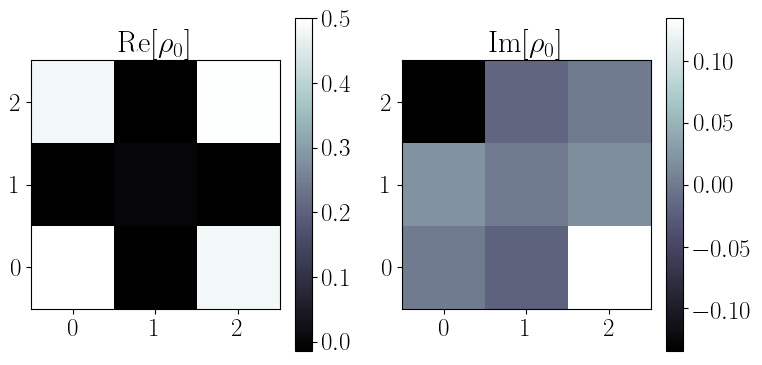

In [75]:

"""
    rho0_from_params(p::NamedTuple) → Matrix{ComplexF64}

Given p = (A, γ, β, B, C), reconstruct the spin-1 pure‐state density matrix ρ₀.
"""
function rho0_from_params(p)
    A, γ, β, B, C = p.A, p.γ, p.β, p.B, p.C

    # amplitudes a₁…a₈
    a1, a2 = A*B*cos(β), A*B*sin(β)
    a3     = 0.5*(A^2 - B^2)
    a4, a5 = A*C*cos(γ), A*C*sin(γ)
    a6, a7 = B*C*cos(γ-β), B*C*sin(γ-β)
    a8     = (-2 + 3A^2 + 3B^2)/(2√3)

    ComplexF64[
      1/3 + a3 + a8/√3     a1 - im*a2        a4 - im*a5;
      a1 + im*a2           1/3 - a3 + a8/√3  a6 - im*a7;
      a4 + im*a5           a6 + im*a7        1/3 - 2*a8/√3
    ]
end


ρ0_opt = rho0_from_params(best_p)


fig, axs = subplots(1, 2, figsize=(8,4))

# real part
im0 = axs[1].imshow(real.(ρ0_opt),
                   interpolation="nearest",
                   origin="lower",
                   aspect="equal", cmap="bone")
axs[1].set_title(L"\mathrm{Re}[\rho_0]")
colorbar(im0, ax=axs[1])

# imaginary part
im1 = axs[2].imshow(imag.(ρ0_opt),
                   interpolation="nearest",
                   origin="lower",
                   aspect="equal", cmap="bone")
axs[2].set_title(L"\mathrm{Im}[\rho_0]")
colorbar(im1, ax=axs[2])

tight_layout()
display(fig)

In [76]:
ρ0_opt

3×3 Matrix{ComplexF64}:
    0.500588+0.0im        -0.00964604-0.0212953im    0.480944+0.134709im
 -0.00964604+0.0212953im   0.00109179+0.0im        -0.0149981+0.0178638im
    0.480944-0.134709im    -0.0149981-0.0178638im     0.49832+0.0im

In [ ]:
params = (Δ1, Δ2, g, ϕ, Δ, κ, η);
prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params);
sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-9, abstol=1e-9; maxiters=1e9);  # If stiff solver needed → pass "TRBDF2(autodiff=false)" to solve()

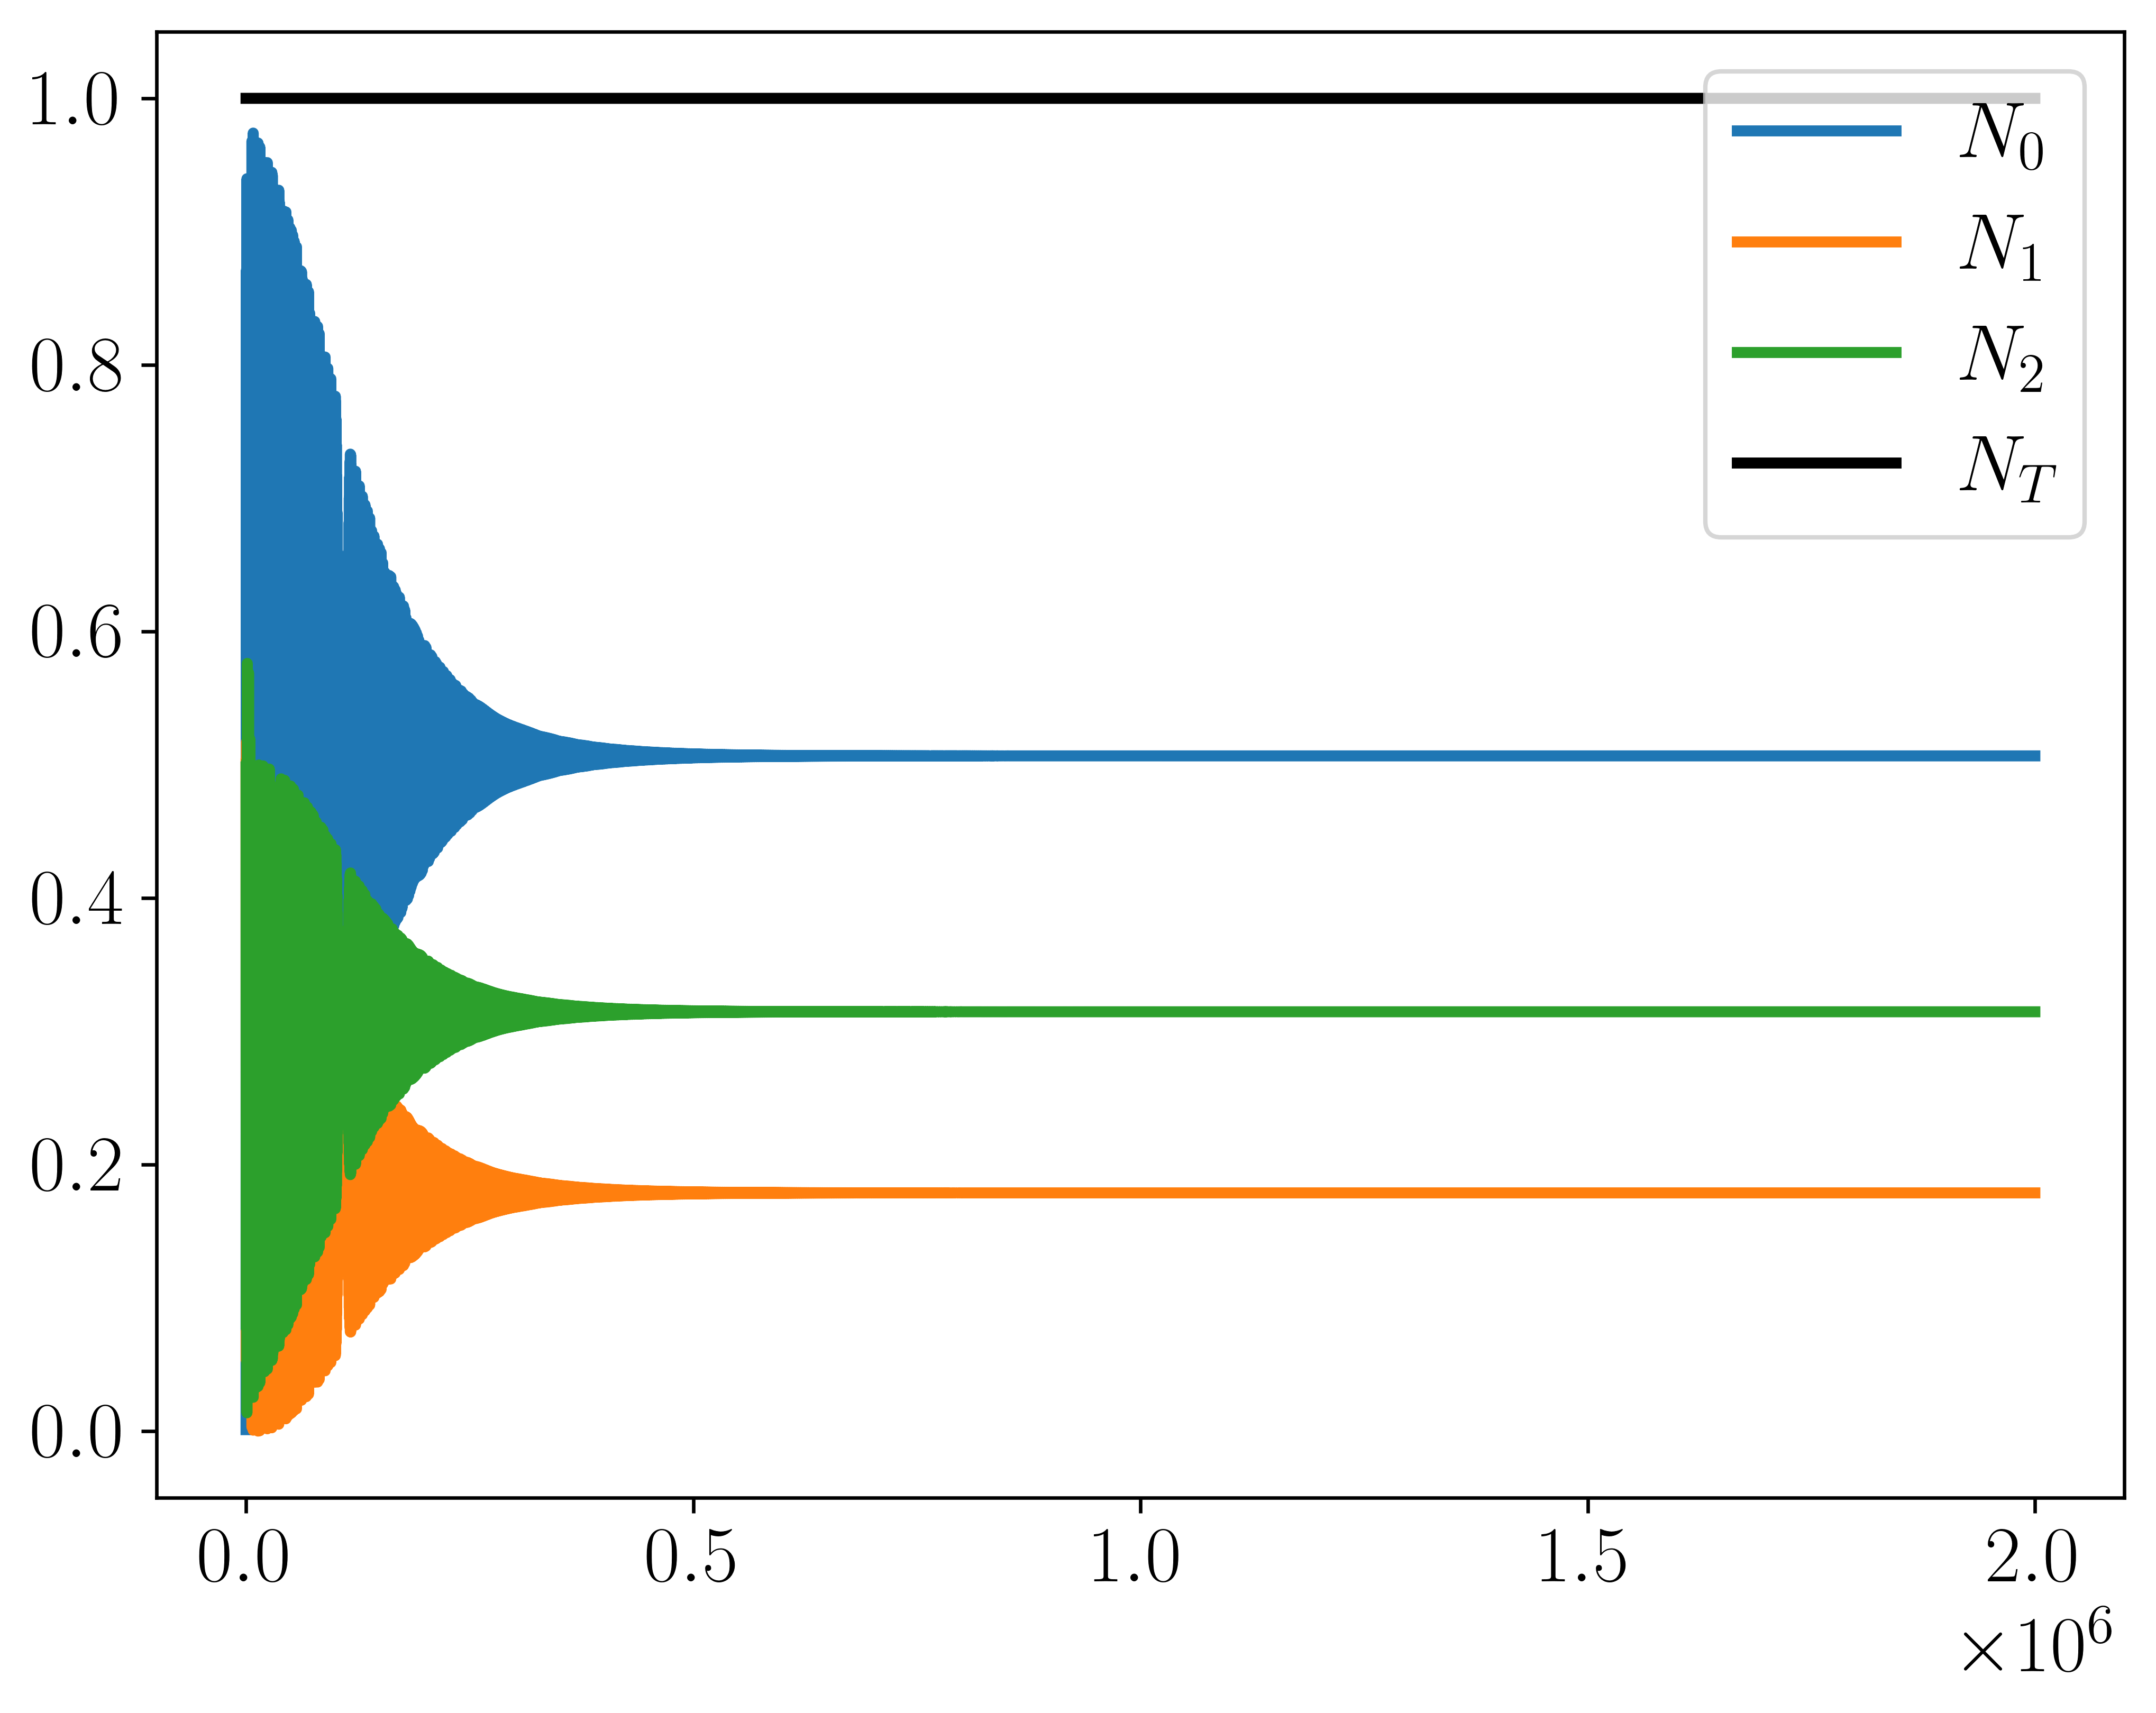

In [47]:
# 1) Rebuild ρ₀ and u0 from your best_params:
ρ0_opt = rho0_from_params(best_p)
# project to λ‐basis
u0 = zeros(10);  
for i in 1:8
    u0[i] = tr(ρ0_opt*λ_matrices[i])
end

# 2) Pack your MFParams + φ into the tuple the ODE expects
φ = 0
ode_params = (mf.Δ1, mf.Δ2, mf.g, φ, mf.Δ, mf.κ, mf.η)

# 3) Build and solve the ODEProblem exactly as before
tspan  = (0.0, t_end)
saveat = range(0, stop=t_end, length=10000)
prob   = ODEProblem(coupled_eqs!, u0, tspan, ode_params)
sol    = solve(prob,Tsit5(),saveat=saveat,reltol=1e-9,abstol=1e-9)

# 4) Extract your populations
N0 = 1/3 .- sol[3,:] .+ sol[8,:]/√3;
N1 = 1/3 .+ sol[3,:] .+ sol[8,:]/√3;
N2 = 1/3 .- 2*sol[8,:]/√3;
Nt = N0 + N1 + N2

fig, ax= subplots(figsize=(8, 6), dpi=600)
ax.plot(sol.t, N0, lw=2.5, label=L"N_0")
ax.plot(sol.t, N1, lw=2.5, label=L"N_1")
ax.plot(sol.t, N2, lw=2.5, label=L"N_2")
ax.plot(sol.t, Nt, lw=2.5, linestyle="-", color="black", label=L"N_T")
# ax.set_xscale("log")
ax.legend(loc="upper right")
display(fig)

In [50]:
var(N1)
best_var

0.13904474279134169